In [1]:
from commonFunctions import  midplaneTemp
from dustpy import Simulation
from dustpy import constants as c
from dustpy import std
import inputFile as pars
import matplotlib.pyplot as plt
import numpy as np
from viscAccDisc import viscAccDisc_grid

In [2]:
plt.rcParams["figure.dpi"] = 150.

In [3]:
mH = c.m_p
Z = 0.01

`np.geomspace` is a bit more comfortable here

In [4]:
ri = np.geomspace(pars.Rin_dust, pars.Redge_dust, pars.Rnr_dust+1)

I would propose to have a couple of more grid cells until 1000 au or so to have the outer edge a bit farther away from the exponential cut-off.

There's most likely a more elegant way of doing this.

In [5]:
ri_outer = np.concatenate([np.arange(pars.Rcoarse_int*(ri[-1]//pars.Rcoarse_int+1.), pars.Rgrid_out, pars.Rcoarse_int), [pars.Rgrid_out]])

In [6]:
ri = np.concatenate([ri, ri_outer])

In [7]:
ri/c.au

array([   1.        ,    1.03595335,    1.07319935,    1.11178446,
          1.15175684,    1.19316636,    1.23606469,    1.28050536,
          1.32654382,    1.37423751,    1.42364596,    1.4748308 ,
          1.52785591,    1.58278746,    1.63969397,    1.69864646,
          1.7597185 ,    1.82298628,    1.88852874,    1.95642768,
          2.02676782,    2.09963691,    2.1751259 ,    2.25332897,
          2.33434369,    2.41827118,    2.50521613,    2.59528705,
          2.68859632,    2.78526037,    2.88539981,    2.98913961,
          3.0966092 ,    3.20794268,    3.32327897,    3.44276199,
          3.56654082,    3.69476992,    3.82760928,    3.96522466,
          4.10778778,    4.25547652,    4.40847517,    4.56697463,
          4.73117267,    4.90127419,    5.07749143,    5.26004426,
          5.44916048,    5.64507607,    5.84803548,    6.05829195,
          6.27610786,    6.50175497,    6.73551486,    6.97767919,
          7.22855015,    7.48844076,    7.7576753 ,    8.03658

In [8]:
t = np.linspace(pars.tstart, pars.tend, int(np.floor(pars.tend/pars.dt_dust)))

In [9]:
sim = Simulation()

Making the custom grid here.

In [10]:
sim.grid.ri = ri

In [11]:
### Grid Configuration
sim.ini.dust.rhoMonomer = pars.rhop
sim.ini.grid.Nmbpd = 7 # Default
sim.ini.grid.mmin = 4./3. * np.pi * sim.ini.dust.rhoMonomer * pars.dustMinSize**3
sim.ini.grid.mmax = 4./3. * np.pi * sim.ini.dust.rhoMonomer * pars.dustMaxSize**3

In [12]:
sim.makegrids()

In [13]:
sim.grid

Group (Grid quantities)
-----------------------
    A            : Field (Radial grid annulus area [cm²]), constant
    m            : Field (Mass grid [g]), constant
    Nm           : Field (# of mass bins), constant
    Nr           : Field (# of radial grid cells), constant
    r            : Field (Radial grid cell centers [cm]), constant
    ri           : Field (Radial grid cell interfaces [cm]), constant
  -----
    OmegaK       : NoneType
  -----

Setting parameters

In [14]:
### Stellar Parameters
sim.ini.star.M = pars.Mstar
sim.ini.star.R = pars.Rstar
sim.ini.star.T = pars.Tstar
# Gas Parameters
sim.ini.gas.alpha = pars.alpha
sim.ini.gas.gamma = 1.0 # Adiabatic index, set to 1 for isothermal
sim.ini.gas.mu = pars.mu*mH
sim.ini.gas.SigmaExp = -pars.sigmaExp
sim.ini.gas.SigmaRc = pars.Rout
### Dust Parameters
sim.ini.dust.aIniMax = pars.a_0
sim.ini.dust.allowDriftingParticles = pars.allowDriftingParticles
sim.ini.dust.d2gRatio = Z
sim.ini.dust.vfrag = pars.vfrag

In [15]:
sim.initialize()

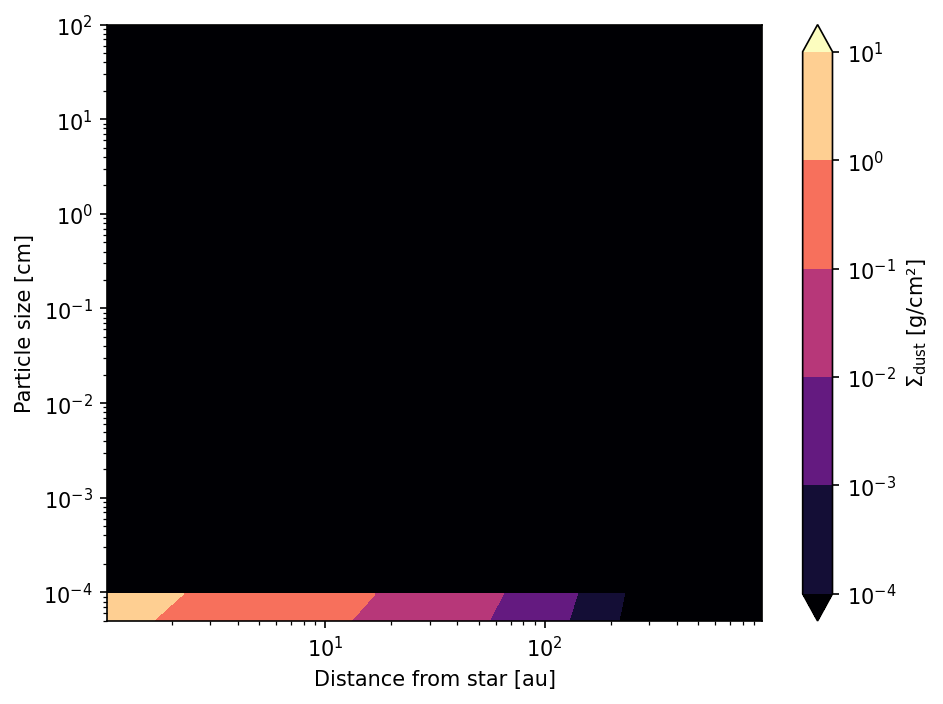

In [16]:
smax = np.ceil(np.log10(sim.dust.Sigma.max()))
levels = np.arange(smax-5, smax+1)
fig, ax = plt.subplots()
plot = ax.contourf(sim.grid.r/c.au, sim.dust.a[0, :], np.log10(sim.dust.Sigma.T), cmap="magma", levels=levels, extend="both")
ax.set(
    xscale="log", yscale="log", xlabel="Distance from star [au]", ylabel="Particle size [cm]"
)
cbar = plt.colorbar(plot)
cbar.set_ticks(levels)
cbar.set_ticklabels(f"$10^{{{int(l)}}}$" for l in levels)
cbar.set_label(r"$\Sigma_\mathrm{dust}$ [g/cm²]")
fig.set_layout_engine("tight")

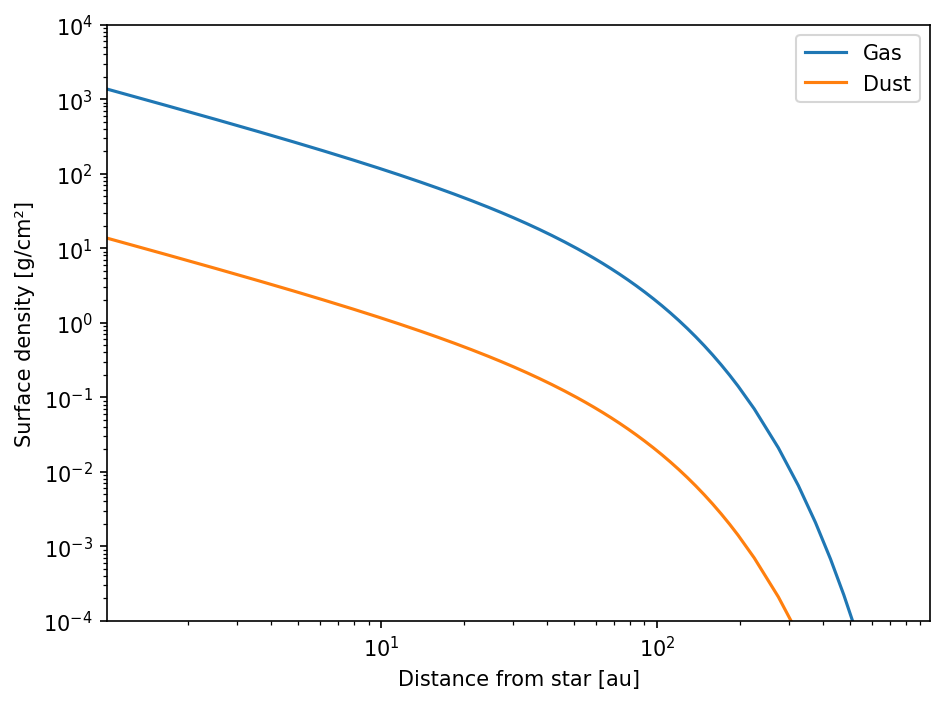

In [17]:
fig, ax = plt.subplots()
ax.loglog(sim.grid.r/c.au, sim.gas.Sigma, label="Gas")
ax.loglog(sim.grid.r/c.au, sim.dust.Sigma.sum(-1), label="Dust")
ax.set(
    xlabel="Distance from star [au]", ylabel="Surface density [g/cm²]",
    xlim=[sim.grid.r.min()/c.au, sim.grid.r.max()/c.au], ylim=[1.e-4, 1.e4]
)
ax.legend()
fig.set_layout_engine("tight")

Modifications

In [18]:
Mdot_gas_0, sigma_gas_0 = viscAccDisc_grid(t[0], sim.grid.r)

In [19]:
Sigma_old = sim.gas.Sigma.copy()
sim.gas.Sigma = sigma_gas_0
sim.dust.Sigma *= (sim.gas.Sigma/Sigma_old)[:,None]
sim.gas.gamma = 1.0 # Adiabatic index, set to 1 for isothermal
sim.gas.T = midplaneTemp(sim.grid.r)
sim.gas.T.updater = None
### Time between saved snapshots
sim.t.snapshots = t
### Different dust diffusivity
sim.dust.delta.rad = pars.alphaTurb
sim.dust.delta.rad.updater = None
sim.dust.delta.turb = pars.alphaTurb
sim.dust.delta.turb.updater = None
sim.dust.delta.vert = pars.alphaTurb
sim.dust.delta.vert.updater = None

Plotting state after modifications

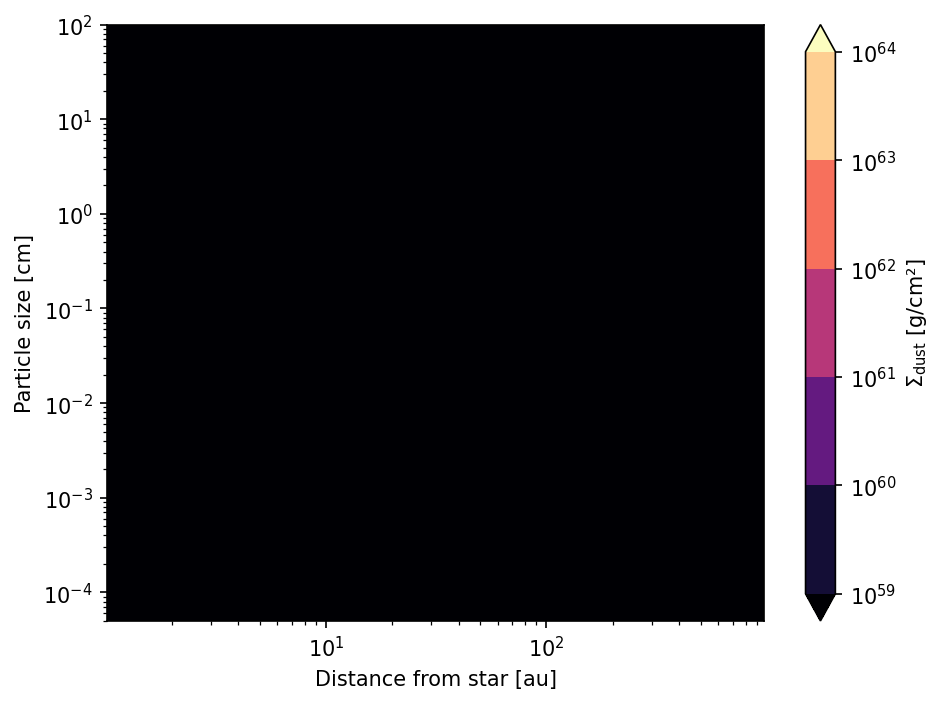

In [20]:
smax = np.ceil(np.log10(sim.dust.Sigma.max()))
levels = np.arange(smax-5, smax+1)
fig, ax = plt.subplots()
plot = ax.contourf(sim.grid.r/c.au, sim.dust.a[0, :], np.log10(sim.dust.Sigma.T), cmap="magma", levels=levels, extend="both")
ax.set(
    xscale="log", yscale="log", xlabel="Distance from star [au]", ylabel="Particle size [cm]"
)
cbar = plt.colorbar(plot)
cbar.set_ticks(levels)
cbar.set_ticklabels(f"$10^{{{int(l)}}}$" for l in levels)
cbar.set_label(r"$\Sigma_\mathrm{dust}$ [g/cm²]")
fig.set_layout_engine("tight")

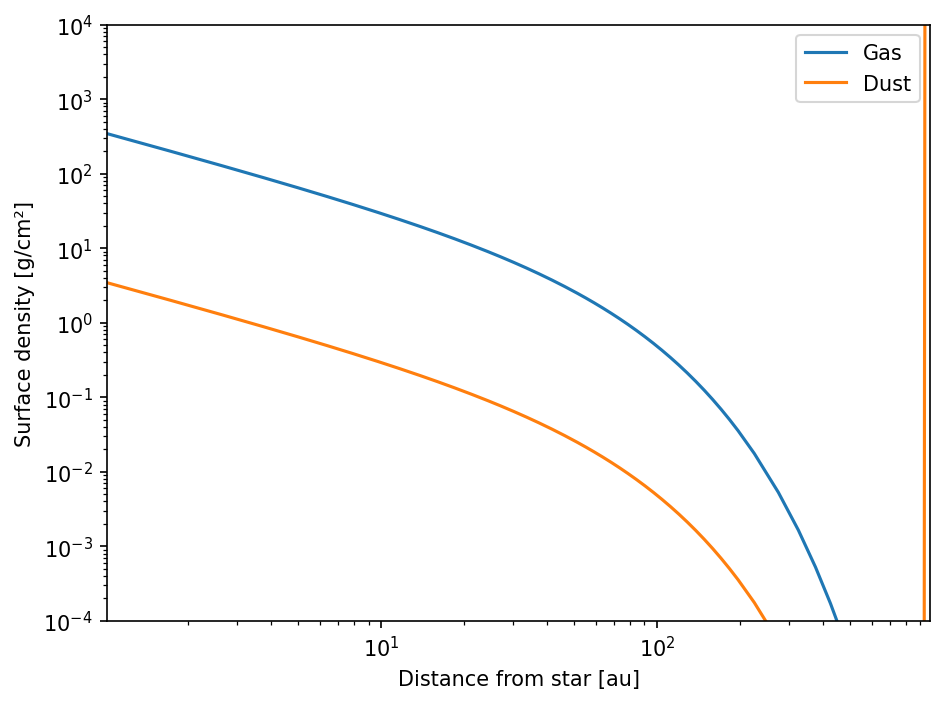

In [21]:
fig, ax = plt.subplots()
ax.loglog(sim.grid.r/c.au, sim.gas.Sigma, label="Gas")
ax.loglog(sim.grid.r/c.au, sim.dust.Sigma.sum(-1), label="Dust")
ax.set(
    xlabel="Distance from star [au]", ylabel="Surface density [g/cm²]",
    xlim=[sim.grid.r.min()/c.au, sim.grid.r.max()/c.au], ylim=[1.e-4, 1.e4]
)
ax.legend()
fig.set_layout_engine("tight")

The is an extremely high peak in surface density at the outermost grid cell. I assume this peak is diffusing into your simulation over time. This is caused by the third line in cell 19. `Sigma_old` has the floor value in the outermost grid cell, while `sigma_gas_0` doesn't.

I would propose the following setup:

First set the new temperature profile and update the gas group.

(Most of the updates are probably not needed immediately. But better to be save than sorry.)

In [22]:
sim.gas.T[...] = midplaneTemp(sim.grid.r)
sim.gas.T.updater = None
sim.gas.update()

Set your desired dust diffusivities and update the dust object.

In [23]:
sim.dust.delta.rad[...] = pars.alphaTurb
sim.dust.delta.rad.updater = None
sim.dust.delta.turb[...] = pars.alphaTurb
sim.dust.delta.turb.updater = None
sim.dust.delta.vert[...] = pars.alphaTurb
sim.dust.delta.vert.updater = None
sim.dust.update()

Set your new gas surface density and update the gas object.

In [24]:
sim.gas.Sigma[...] = sigma_gas_0
sim.gas.update()

Use the DustPy default functions to create the dust surface density.

In [25]:
sim.dust.Sigma[...] = std.dust.MRN_distribution(sim)
sim.dust.update()

Update the entire simulation object and invoke the finalizer of the integrator to set properly set the boudnary conditions.

In [26]:
sim.update()
sim.integrator._finalize()

Now the simulation should be consistent and ready to go.

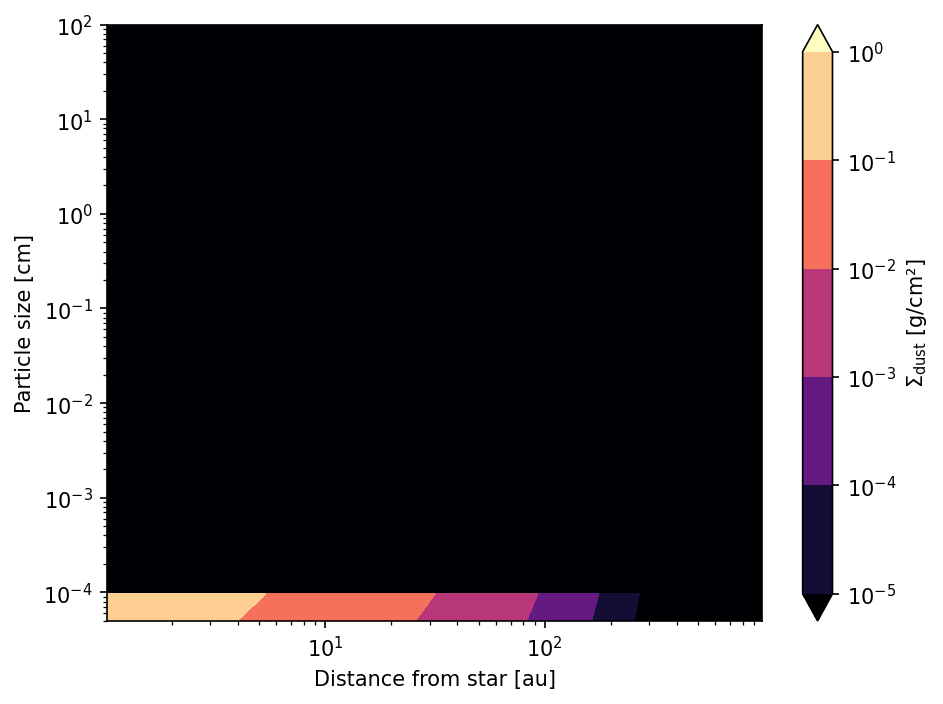

In [27]:
smax = np.ceil(np.log10(sim.dust.Sigma.max()))
levels = np.arange(smax-5, smax+1)
fig, ax = plt.subplots()
plot = ax.contourf(sim.grid.r/c.au, sim.dust.a[0, :], np.log10(sim.dust.Sigma.T), cmap="magma", levels=levels, extend="both")
ax.set(
    xscale="log", yscale="log", xlabel="Distance from star [au]", ylabel="Particle size [cm]"
)
cbar = plt.colorbar(plot)
cbar.set_ticks(levels)
cbar.set_ticklabels(f"$10^{{{int(l)}}}$" for l in levels)
cbar.set_label(r"$\Sigma_\mathrm{dust}$ [g/cm²]")
fig.set_layout_engine("tight")

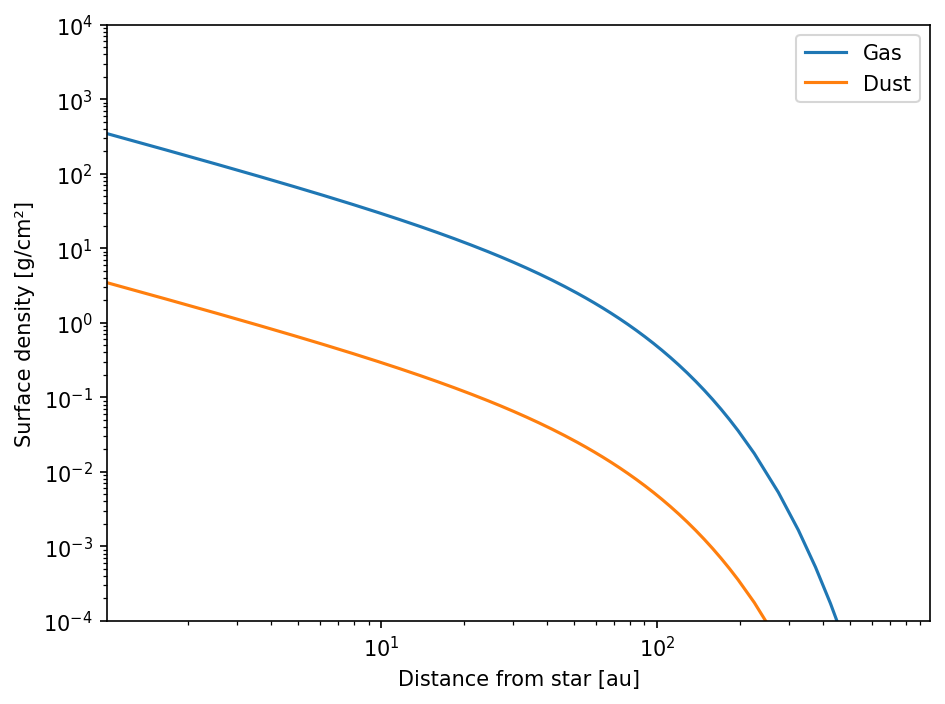

In [28]:
fig, ax = plt.subplots()
ax.loglog(sim.grid.r/c.au, sim.gas.Sigma, label="Gas")
ax.loglog(sim.grid.r/c.au, sim.dust.Sigma.sum(-1), label="Dust")
ax.set(
    xlabel="Distance from star [au]", ylabel="Surface density [g/cm²]",
    xlim=[sim.grid.r.min()/c.au, sim.grid.r.max()/c.au], ylim=[1.e-4, 1.e4]
)
ax.legend()
fig.set_layout_engine("tight")